In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Load the data
master = pd.read_csv('master1.csv')

# Filter relevant crime types
relevant_crime_types = ['HOMICIDE', 'BATTERY', 'ASSAULT', 'ROBBERY', 'CRIMINAL SEXUAL ASSAULT']
master = master[master['Primary Type'].isin(relevant_crime_types)]

# Drop irrelevant columns
columns_to_drop = ['Case Number', 'Time', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic','Beat','District','Ward','Community Area','FBI Code','X Coordinate',
                'Y Coordinate','Updated On','Latitude','Longitude','Location', 'Holiday Day of Week','precipprob','snowdepth','preciptype', 'windgust','winddir',
                'solarenergy','sunrise', 'sunset','moonphase', 'description', 'icon','stations']
data = master.drop(columns=columns_to_drop)

# Replace NaN values with 0 indicating no holiday and severe risk
data['Holiday'] = data['Holiday'].fillna(0)
data['severerisk'] = data['severerisk'].fillna(0)

# Replace non-NaN values with 1 indicating a holiday
data['Holiday'] = data['Holiday'].apply(lambda x: 1 if x != 0 else 0)

# Filter data for years after 2010
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y')
data = data[data['Date'].dt.year >= 2010]

# Group by date and get crime counts
daily_counts = data.groupby('Date').size().reset_index(name='Crime_Count')

# Merge daily counts with the original DataFrame
merged_data = pd.merge(data, daily_counts, on='Date')

# Drop duplicate rows to keep only one entry per day
final_data = merged_data.drop_duplicates(subset='Date')

# Split conditions column and create dummy variables
final_data['conditions'] = final_data['conditions'].str.split(',')
final_data = final_data.join(final_data['conditions'].str.join('|').str.get_dummies())

# Drop unnecessary columns
final_data.drop(columns=['conditions'], inplace=True)

C:\Users\Matt\AppData\Local\Temp\ipykernel_11640\3022355488.py:10: DtypeWarning: Columns (23,24,36,49,50,52,53,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  master = pd.read_csv('master1.csv')
C:\Users\Matt\AppData\Local\Temp\ipykernel_11640\3022355488.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['conditions'] = final_data['conditions'].str.split(',')


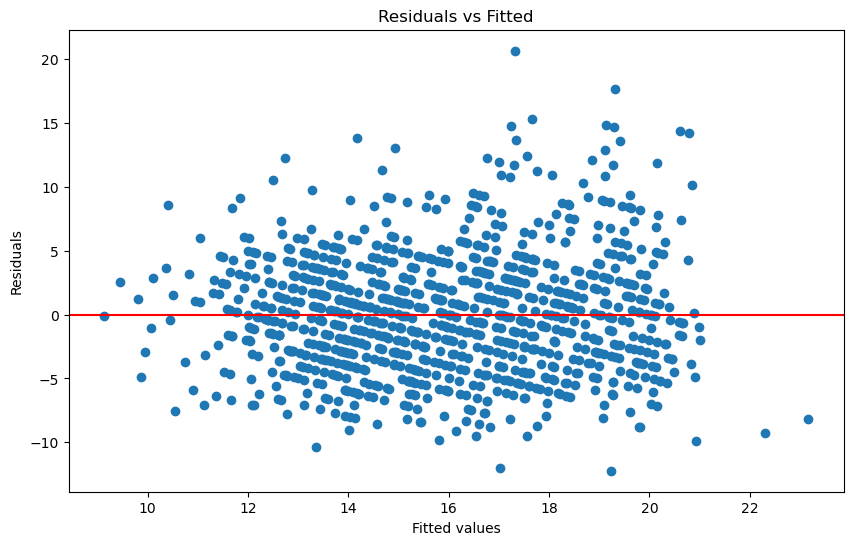

<Figure size 1000x600 with 0 Axes>

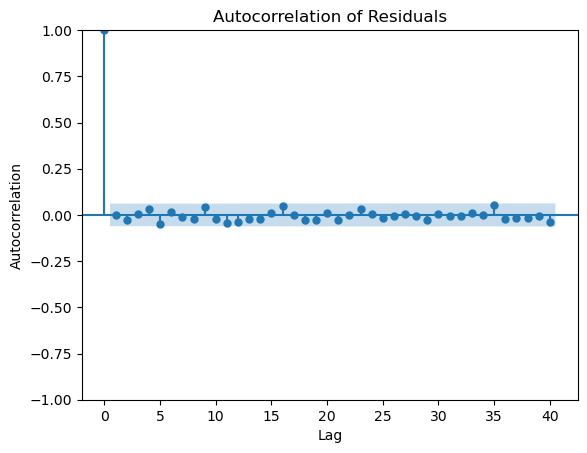

<Figure size 1000x600 with 0 Axes>

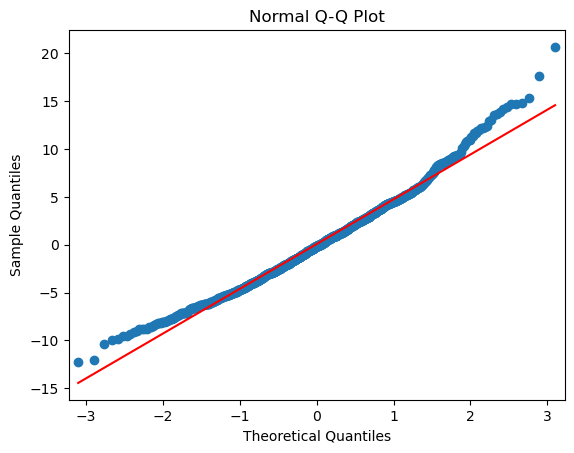

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals calculation
X = final_data.drop(columns=['Crime_Count', 'ID', 'Date'])
y = final_data['Crime_Count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
residuals = y_test - y_pred

# 1. Linearity
# Check linearity using residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# 2. Independence of residuals
# Check for autocorrelation using autocorrelation plot
plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# 4. Normality of residuals
# Check for normality using Q-Q plot
plt.figure(figsize=(10, 6))
sm.qqplot(residuals, line='s')
plt.title('Normal Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()


In [11]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test for normality
statistic, p_value = shapiro(residuals)
print("Shapiro-Wilk Test:")
print("Statistic:", statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value > alpha:
    print("The residuals are normally distributed (fail to reject H0)")
else:
    print("The residuals are not normally distributed (reject H0)")

Shapiro-Wilk Test:
Statistic: 0.9840729236602783
p-value: 3.3836158319644483e-09
The residuals are not normally distributed (reject H0)


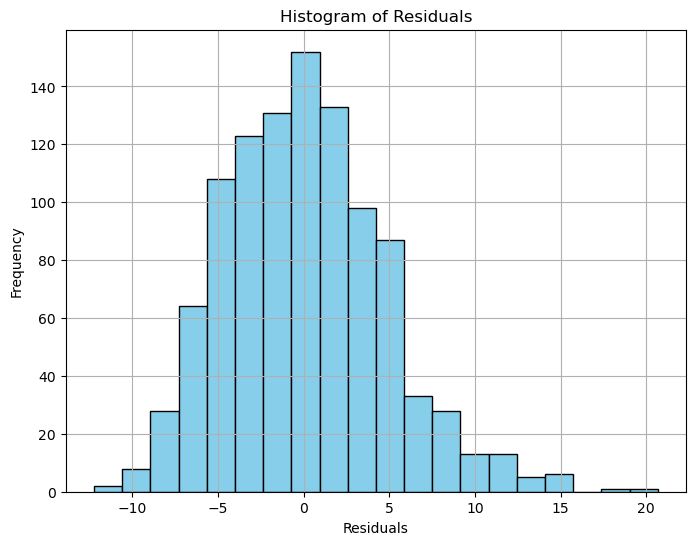

In [12]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred

# Plot histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()